# Chapter 6. 신경망

이번 주제는 신경망입니다. 인류는 생성 모델과 신경망을 결합하여 지금까지 많은 혁신을 이루어냈습니다. 

이번 장에서는 신경망 프레임워크인 파이토치 사용법을 소개합니다. 그런 다음 기초적인 머신러닝 문제인 선형회귀를 풀고, 
마지막으로 신경망을 구현하는 순서로 진행하겠습니다. 

이미 신경망을 잘 아는 분, 특히 파이토치를 사용해본 분은 이번 장을 건너뛰어도 무방합니다.

## 6.1 파이토치와 경사법

이 책에서는 신경망 프레임워크로 파이토치를 사용합니다. 먼저 파이토치를 설치하고 사용법을 간단히 알아보겠습니다.

### 6.1.1 파이토치 설치

파이토치는 다음 명령어로 설치할 수 있습니다.

In [ ]:
pip install torch

설치가 완료되면 다음 코드를 실행합니다. 파이토치 버전이 출력되면 제대로 설치된 것입니다.

In [5]:
import torch

# 버전 출력
print(torch.__version__) # 2-x.x

2.4.1+cpu


이 책에서는 파이토치 2.0.0 이상을 사용합니다. 단, 기본적인 기능만 사용하므로 다른 버전에서도 그대로 동작하거나 약간만 수정하면 문제를 바로잡을 수 있을 것입니다.

### 6.1.2 텐서 계산

설치를 끝냈으니 사용해봅시다. tensor 클래스부터 시작하겠습니다. tensor는 텐서, 즉 다차원 배열을 표현한 클래스입니다. 넘파이의 np.ndarray와 똑같이 취급할 수 있습니다. 
다음 코드를 예시로 실행해봅시다.

In [7]:
import torch

x = torch.tensor(5.0)
y = 3 * x ** 2 

print(y)

tensor(75.)


보다시피 넘파이와 마찬가지로 조작법이 직관적입니다.  

이제 미분을 구해보겠습니다. 앞의 코드에서는 y = 3 * x ** 2라는 계산을 했습니다.  
이 계산의 x=5에서 미분을 구해봅시다. 먼저 수식으로 답을 구해보겠습니다.  
이번 계산은 수식으로 y = 3x^2이며 미분은 dy/dx = 6x입니다. x = 5를 대입하면 정답은 30입니다. 

코드에서도 30이 나오는지 확인해봅시다. 파이토치에서 미분은 tensor 인스턴스의 backward() 메서드로 구합니다. 

코드는 다음과 같습니다.

In [ ]:
x = torch.tensor(5.0, requires_grad=True) # 미분 가능하도록 설정 
y = 3 * x ** 2

y.backward()
print(x.grad)

tensor(30.)


미분이 필요한 텐서에는 생성 시 인수로 requires_grad=True를 지정합니다.  
앞으로 미분을 계산할 일이 있다고 알려주는 것입니다.  
이렇게 만든 텐서를 이용하여 계산한 y 역시 tensor 인스턴스이고, backward() 메서드를 호출하여 미분을 구할 수 있습니다.  
결과는 30.0이군요. 수식으로 얻은 답과 일치합니다. 

#### ℹ️ **참고**: PyTorch의 backward() 원리 간단 명확히 이해하기

##### 1. Forward와 Backward의 개념

- **Forward**: 입력값에서 출력값까지 순서대로 계산을 진행합니다. 

  예) $ z = x^2 $

- **Backward**: 출력값에서 시작해 입력까지 거꾸로 돌아가며 미분을 계산하는 단계입니다.  

  예) $ \frac{dz}{dx} = 2x $

> Forward와 backward는 서로 연결된 짝입니다!

---

##### 2. PyTorch가 Forward 연산에서 하는 일

PyTorch는 forward 연산을 할 때마다 내부적으로 **연산 그래프**를 기록합니다.

예를 들어, 연산이 다음과 같다면:

$ z = x^2 $

PyTorch는 다음을 기억합니다.

- 계산된 값 (여기서는 x의 값)
- 어떤 연산이 이루어졌는지(제곱 연산)
- backward를 위해 저장한 값 (`ctx.save_for_backward`로 내부에서 관리)

이렇게 생성된 그래프는 나중에 미분을 계산할 때 활용됩니다.

---

##### 3. backward()가 미분을 계산하는 방법

PyTorch가 backward() 메서드를 호출하면, 내부적으로 다음과 같은 과정이 진행됩니다.

- 계산된 그래프를 **뒤에서부터 거꾸로 따라가면서** 미분을 계산합니다.
- forward 단계에서 저장했던 값을 사용합니다.
- 미리 정의된 미분 공식(analytical derivative)을 이용해 각 노드에서의 미분을 계산합니다.

예시:
- Forward: $ z = x^2 $
- Backward: $ \frac{dz}{dx} = 2x $

이 과정으로 최종 미분값을 얻고, 결과는 자동으로 텐서의 `.grad` 속성에 저장됩니다.

---

##### 4. Backward 미분 공식은 미리 준비되어 있다

PyTorch는 자주 사용되는 연산마다 이미 수학적으로 미분 공식이 정의되어 있습니다.

| Forward 연산 | Backward 미분 |
|--------------|---------------|
| $ z = x^2 $     | $ \frac{dz}{dx}=2x $|
| $ z = x \times y $ | $ \frac{dz}{dx}=y, \quad \frac{dz}{dy}=x $|
| $ z = e^x $     | $ \frac{dz}{dx}=e^x $|

즉, backward가 forward와 짝지어 미리 준비된 공식으로 계산되는 것입니다.

---

##### 5. 쉽게 이해하는 예시

- Forward를 할 때 PyTorch는 땅에 발자국(연산 그래프)을 찍어둡니다.
- backward는 그 발자국을 따라 거꾸로 돌아가며, 각 발자국에서 준비된 미분 공식으로 계산하여 최종적인 미분값을 얻는 것입니다.

이 원리를 이용해 PyTorch는 복잡한 모델에서도 빠르고 효율적으로 미분값을 자동으로 계산합니다.

>**NOTE** backward라는 이름은 역전파 backpropagation (오차 역전파법)에서 유래했습니다. 역전파는 미분을 효율적으로 구하는 알고리즘입니다.  
순방향 계산 forward과 역방향 계산 backward을 통해 각 변수의 미분을 구할 수 있습니다(역방향 계산은 미분을 반대 방향으로 전파합니다).  
역전파 메커니즘에 대해서는「밑바닥부터 시작하는 딥러닝」1권을 참고하기 바랍니다

#### ℹ️ **참고**: 간단한 DNN(Deep Neural Network)의 역전파(Backpropagation) 설명

##### 1. 개요

딥러닝에서 역전파(Backpropagation)는 신경망의 가중치를 업데이트하기 위해 사용하는 핵심 알고리즘입니다. 역전파는 **연쇄법칙(Chain Rule)**을 이용하여 손실(Loss)이 모델의 각 가중치(Weight)에 미치는 영향을 계산합니다.

이 문서에서는 간단한 DNN을 예시로 들어 역전파 과정을 설명하고, 연쇄법칙의 개념을 함께 정리하겠습니다.

---

##### 2. 간단한 DNN 구조

간단한 3층 신경망을 고려해 봅시다.

<p align="center"><img src="./img/fig-06-00.png" width="50%"></p>

```
입력층 (Input) → 은닉층 (Hidden) → 출력층 (Output)
```

수식적으로 나타내면,

1. **Forward 과정** (순전파)
   - 은닉층에서 활성화 함수 적용:
     $$ h = W_1 x + b_1 $$
   - 비선형 변환 (ReLU 또는 Sigmoid 등 적용):
     $$ a = f(h) $$
   - 출력층에서 예측값 계산:
     $$ y_{pred} = W_2 a + b_2 $$
   
2. **Loss 계산**
   - 예측값과 실제값 사이의 차이:
     $$ L = \frac{1}{2} (y_{pred} - y_{true})^2 $$

3. 간단한 DNN 학습의 원리

   - 딥러닝 모델의 학습은 예측 오차, 즉 **Loss**를 최소화하는 방향으로 가중치 \( W_1 \)과 \( W_2 \)를 점진적으로 업데이트하는 과정입니다. 이를 통해 최적의 가중치를 찾아 모델이 주어진 데이터에 잘 맞도록 최적화됩니다. 학습 과정에서 가중치는 다음과 같은 방식으로 조정됩니다.

      $$
      W_1 = W_1 - lr \frac{\partial L}{\partial W_1}, \quad W_2 = W_2 - lr \frac{\partial L}{\partial W_2}
      $$

      여기서 $lr$ 는 학습률(Learning Rate)이며, 손실 함수 \( L \)의 기울기(Gradient)를 활용하여 가중치를 점진적으로 업데이트함으로써 모델의 성능을 향상시킵니다.

---

##### 3. 연쇄법칙(Chain Rule) 설명

연쇄법칙이란, 합성함수의 미분을 계산하는 원리입니다.

예를 들어, 함수가 다음과 같이 주어진다면:

$$ z = f(g(x)) $$

미분은 다음과 같이 계산됩니다.

$$ \frac{dz}{dx} = \frac{dz}{dg} \cdot \frac{dg}{dx} $$

역전파에서 모든 노드에서의 미분은 연쇄법칙을 적용하여 이전 층의 기울기를 반영하며 업데이트됩니다.

---

##### 4. 역전파 과정 (Backpropagation)

역전파는 손실 함수의 미분을 이용하여 각 가중치에 대한 변화량을 계산하는 과정입니다. **연쇄법칙을 사용하여** 계산이 이루어집니다.

1. **출력층에서의 미분**
   $$ \frac{\partial L}{\partial y_{pred}} = y_{pred} - y_{true} $$
   $$ \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial y_{pred}} \cdot \frac{\partial y_{pred}}{\partial W_2} = (y_{pred} - y_{true}) \cdot a $$

2. **은닉층에서의 미분 (연쇄법칙 적용)**
   $$ \frac{\partial L}{\partial a} = \frac{\partial L}{\partial y_{pred}} \cdot W_2 $$
   $$ \frac{\partial L}{\partial h} = \frac{\partial L}{\partial a} \cdot f'(h) $$
   $$ \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial h} \cdot x $$

3. **가중치 업데이트 (Gradient Descent 적용)**
   $$ W_1 = W_1 - lr * \frac{\partial L}{\partial W_1} $$
   $$ W_2 = W_2 - lr * \frac{\partial L}{\partial W_2} $$
   여기서 $lr$는 학습률(Learning Rate)입니다.

---

##### 5. 시각적 이해 (그림 참고)

아래와 같은 계산 그래프를 통해 역전파를 이해할 수 있습니다.

```
   x → [W1] → h → [활성화 함수] a → [W2] → y_pred
                                             ↓
                                          손실 L
```

역전파 과정은 그래프의 끝에서 시작하여 거꾸로 가중치의 기울기를 계산하는 방식으로 진행됩니다.

---

##### 6. 마무리

- **순전파(Forward Pass)**: 입력을 받아 출력을 계산하는 과정
- **손실(Loss) 계산**: 예측값과 실제값의 차이
- **역전파(Backward Pass)**: 연쇄법칙을 사용해 미분을 계산
- **가중치 업데이트**: 경사하강법(Gradient Descent) 적용

이 과정이 반복되며 모델이 학습하게 됩니다!



### 6.1.3 경사법

간단한 문제를 파이토치를 이용하여 풀어봅시다. 다음 식으로 표현되는 함수의 최솟값을 찾고자합니다.

$$ y = 100 (x_1 - x_0^2)^2 + (x_0 - 1)^2 $$


이 함수를 로젠브록 함수라고 합니다. ［그림 6-1］과 같이 함수의 형태가 독특하여 최솟값을 찾기가 어렵습니다. 그래서 최적화문제의 벤치마크로 널리 쓰입니다.

<p align="center"><img src="./img/fig-06-01.png" width="50%"></p>

목표는 로젠브록 함수의 출력이 최소가 되는 x0과 x1 찾기입니다. 이 문제는 해석적으로 풀 수 있습니다.  
다음 식을 풀면 됩니다.

$$
\begin{cases} 
\frac{\partial y}{\partial x_0} = 400x_0^3 - 400x_0 x_1 + 2x_0 - 2 = 0 \\
\frac{\partial y}{\partial x_1} = 200x_1 - 200x_0^2 = 0
\end{cases}
$$


이 연립방정식을 풀면 $(x_0, x_1) = (1, 1)$ 이 되므로 로젠브록 함수의 최솟값이（1, 1）위치에 있음을 알 수 있습니다.  
이번 절에서는 파이토치를 이용하여 경사법으로 최솟값을 찾을 수 있는지 확인합니다.（경사법에 대해서는 잠시 후에 설명합니다)

우선 로젠브록 함수의 $(x_0, x_1) = (0, 2)$에서 미분을 구해봅시다.  
(수식으로는 $\frac{\partial y}{\partial x_0}$ 와 $\frac{\partial y}{\partial x_1}$).  
파이토치로는 다음과 같이 구현할 수 있습니다.

In [9]:
import torch

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

x0 = torch.tensor(0.0, requires_grad=True)
x1 = torch.tensor(2.0, requires_grad=True)

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)

tensor(-2.) tensor(400.)


x0=0.0과 xl=2.0에서 미분은 각각 -2와 400이리고 알려주네요.  
이때 두 미분을 합친 것, 즉 -2, 400）이라는 벡터 형태로 표현한 것을 기울기 gradient 라고 힙니다.  
그림으로는 [그림 6-2]와 같습니다.

<p align="center"><img src="./img/fig-06-02.png" width="50%"></p>

기울기는 각 지점에서 함수의 출력을 가장 크게 증가시키는 방향을 나타냅니다. 지금 예에서는 xO, xl） =（0, 2）지점에서 y 값을 가장 크게 증가시키는 방향은 (—2, 400) 이라는 뜻입니다. 

반대로 말하면, 기울기에 마이너스를 곱한（2, -400）방향이 y 값을 가장 크게 감소시키는 방향이라는 뜻이기도 합니다.

> **NOTE** 형상이 복잡한 함수 대부분은 기울기가 가리키는 방향에 최댓값이 존재하지 않을 수도 있습니다（또는 기울기 반대 방향이 꼭 최솟값의 위치를 가리키는 것은 아닙니다）. 그러나 국소적인 영역으로 한정하면 기울기가 함수의 출력을 가장 크게 하는 방향을 나타냅니다. 그래서 기울기 방향으로 일정 거리만큼 이동하고 
이동한 위치에서 다시 기울기를 구하는 일을 반복하면 점차 원하는 위치（최댓값이나 최솟값）에 가까워지리라 기대하는 것입니다. 이 방법을 **경사법 gradient method** 이라고 합니다

이제 경사법을 문제에 적용해보겠습니다. 지금의 문제는 로젠브록 함수의 최솟값 찾기입니다.  
그래서 기울기에 마이너스를 곱한 방향으로 진행합니다. 이 점에 유의하면 다음과 같이 구현할 수 있습니다.

In [ ]:
x0 = torch.tensor(0.0, requires_grad=True)
x1 = torch.tensor(2.0, requires_grad=True)

iters = 10000   # 1. 반복횟수 iteration count
lr = 0.001      # 2. 학습률 learning rate

for i in range(iters):
    if i % 1000 == 0:
        print(x0.item(), x1.item())

    y = rosenbrock(x0, x1)

    y.backward()

    # 3. 값 갱신
    x0.data -= lr * x0.grad.data
    x1.data -= lr * x1.grad.data

    # 4. 기울기 재설정
    x0.grad.zero_()
    x1.grad.zero_()

print(x0.item(), x1.item()) # 5. 결과 출력

0.0 2.0
0.6837119460105896 0.4659528136253357
0.8263181447982788 0.6820318102836609
0.8947840929031372 0.8001903295516968
0.9334872364997864 0.8711214661598206
0.9569892883300781 0.9156519174575806
0.9718162417411804 0.9443121552467346
0.9813804626464844 0.9630323052406311
0.98763507604599 0.9753732085227966
0.9917610883712769 0.983556866645813
0.9944981336593628 0.9890044331550598


1. 갱신 반복 횟수는 iters 변수에 설정했습니다. iters는 iterations의 약자입니다. 
2. 기울기에 곱할 값 역시 lr 변수에 미리 설정했습니다. lr은 learning rate （학습률）의 머리글자입니다.
3. 텐서값 갱신은 x0.data -= lr * x0.grad.data 코드에서 수행합니다. 여기서 x0과 x0.grad는 모두 tensor 인스턴스라는 점에 유의해야 합니다.  
    실제 데이터는 그 속성인 x0.data와 x0.grad.data에서 확인할 수 있습니다. 파이토치에서는 값을 갱신할 때 이처럼 .data 속성을 변경합니다.

>**NOTE** 이 코드의 for 문에서는 x0과 x1 이라는 tensor 인스턴스를 반복적으로 사용하여 미분을 구합니다. 이때 x0.grad와 x1.grad 변수에는 미분값이 계속 누적되기 때문에 새로 미분을 구할 때는 앞서 더한 미분값을 제거해줘야 합니다.  
4. 그래서 다음 번 역전파에 앞서 각 변수의 zero_() 메서드를 호출하여 값을 재설정하고 있습니다.
5. 마지막 print（x0.item（）, xl.itemQ） 코드에서 결과를 출력합니다. item() 메서드는 스칼라 tensoㄱ（즉, 원소가 하나뿐인 tensor）에서 사용할 수 있습니다.  
이 메서드는 tensor의 스칼라값을 파이썬의 숫자 타입 （float 또는 int）으로 변환해 알려줍니다. 손실이나 평가 지표의 값을 로그에 기록하거나 출력할 때 주로 사용합니다.

시작점인（0.0, 2.0）에서 출발하여 위치가 계속 갱신되는 모습을 볼 수 있습니다. 최종적으로 정답에 가까운（0.99-0.98…）이라는 답을 얻었습니다. ［그림 6-3］은 이 결과를 그래프로 그린 모습입니다.

<p align="center"><img src="./img/fig-06-03.png" width="50%"></p>

## 6.2 선형 회귀

머신러닝은 데이터를 이용해 문제를 해결힙니다. 해결책을 사람이 고안하는 것이 이니라 수집된 데이터를 보고 컴퓨터가 발견(학습)한다는 뜻입니다. 이처럼 데이터에서 해답을 찾는 것이 
머신러닝의 본질입니다. 이번 절에서는 파이토치를 이용하여 머신러닝 문제를 해결합니다. 먼저 머신러닝에서 가장 기본이 되는 선형 회귀를 구현해봅시다.

### 6.2.1 토이 데이터셋

파이토치를 이용해 실제 문제를 하나 풀어보겠습니다. 먼저 실험용으로 작은 데이터셋을 만듭니다. 이러한작은 데이터셋을 토이 데이터셋 toy dataset이라고 합니다. 여기서는 다음 식으로 표 
현되는 (x,y) 데이터셋을 만듭니다.
$$y = 2x + 5 + \epsilon$$

이 식에서 $\epsilon$은 노이즈를 뜻하며 0에서 1 사이 무작위 수를 균등 분포에서 생성한다고 가정합니다. 노이즈를 추가하는 이유는 무엇일까요? 현실 문제에서는 노이즈 때문에 정확한 실제 값 
을 측정할 수 없는 일이 흔하기 때문입니다. 

또한 이번 절에서는 똑같은 데이터를 언제든 다시 만들어낼 수 있도록 무작위 수를 생성하는 시드 seed를 고정하였습니다. 파이토치에서는 torch, manual_seed() 함수를 사용하여 시드를 고정합니다. 

코드는 다음과 같습니다.

In [ ]:
import torch

torch.manual_seed(0) # 시드 고정
x = torch.rand(100, 1)
y = 2 * x + 5 + torch.rand(100, 1)

이와 같이 x와 y라는 두 변수로 구성된 데이터셋을 만듭니다. 이때 점들은 직선을 중심으로 분포하며 y에는 0에서 1 사이의 무작위 수가 노이즈로 추가되어 있습니다. 만들어진 (x, y) 점 
들을 2차원 평면에 나타내면 ［그림 6-4］와 같은 모양이 됩니다.

<p align="center"><img src="./img/fig-06-04.png" width="50%"></p>

이 그림에서 x와 y는 선형 관계임을 알 수 있습니다. 우리의 목표는 x 값을 보고 y 값을 예측할 수 있는 모델 (수식)을 만드는 것입니다.

### 6.2.2 선형 회귀 이론

지금 $y$와 $x$의 관계가 선형이라고 가정하고 있습니다. 따라서 $x$로부터 예측되는 $y$($\hat{y}$로 표기)는 다음 식으로 표현할 수 있습니다.

$$
\hat{y} = Wx + b
$$

여기서 $W$와 $b$는 매개변수입니다($W$는 스칼라라고 가정). 이번 문제는 데이터에 노이즈가 섞여 있기 때문에 $y$와 $\hat{y}$에 오차가 있습니다. 이때 오차 $y - \hat{y}$이 다음과 같이 정규 분포를 따른다고 가정합니다.

- $y - \hat{y}$이 평균 0, 표준 편차 $\sigma$인 정규 분포를 따른다.

이 말은 다음과 같은 뜻이기도 합니다.

- $y$는 평균 $\hat{y}$, 표준 편차 $\sigma$인 정규 분포를 따른다.

수식으로 표현해보면,

$$
\hat{y} = Wx + b
$$

$$
p(y \mid x; W, b) = \mathcal{N}(y; \hat{y}, \sigma)
$$

여기서 $p(y \mid x; W, b)$는 $x$가 주어졌을 때 $y$의 확률(조건부 확률)을 뜻합니다. 이때 로그 가능도는 다음과 같이 계산할 수 있습니다.

$$
\log p(y \mid x; W, b) = \log \mathcal{N}(y; \hat{y}, \sigma)
$$

$$
= \log\left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y - \hat{y})^2}{2\sigma^2}\right)\right)
$$

$$
= -\frac{1}{2\sigma^2}(y - \hat{y})^2 + \log\frac{1}{\sqrt{2\pi\sigma^2}} \\
$$

$$
= -\frac{1}{2\sigma^2}(y - Wx - b)^2 + \log\frac{1}{\sqrt{2\pi\sigma^2}} \\
$$

이 식에서 매개변수($W$와 $b$)가 포함된 항은 $-\frac{1}{2\sigma^2}(y - Wx - b)^2$입니다. 로그 가능도를 최대화하는 매개변수를 찾는 것이 목표이므로 $-\frac{1}{2\sigma^2}(y - Wx - b)^2$을 목적 함수로 생각할 수 있습니다.

또한 $\sigma^2$의 값은 목적 함수를 최대화하는 매개변수의 값에 영향을 주지 않으니 무시해도 됩니다. 그리고 목적 함수에 마이너스를 붙이면 매개변수를 최소화하는 문제로 바꿀 수 있습니다. 이상의 내용을 수식으로 표현하면 다음과 같습니다.

$$
\begin{aligned}
\underset{W,b}{\mathrm{arg\,max}}\, \log p(y \mid x; W,b)
&= \underset{W,b}{\mathrm{arg\,max}}\left(-\frac{1}{2\sigma^2}(y - Wx - b)^2\right) \\
&= \underset{W,b}{\mathrm{arg\,max}}\left(-(y - Wx - b)^2\right) \\
&= \underset{W,b}{\mathrm{arg\,min}}\,(y - (Wx + b))^2
\end{aligned}
$$

결과적으로 풀어야 할 문제가 $y$와 $\hat{y}=Wx+b$의 제곱 오차를 최소화하는 문제로 바뀌었습니다. 지금까지는 데이터가 하나일 때의 이야기였습니다. 실제로는 데이터가 $N$개일 때를 생각해야 하므로 최소화 함수는 다음 식과 같습니다.

$$
L(W,b) = \frac{1}{N}\sum_{n=1}^{N}\left(y^{(n)}-(Wx^{(n)}+b)\right)^2 \quad \text{[식 6.1]}
$$

최소화할 대상인 함수 $L(W,b)$를 **손실 함수(loss function)**라고도 합니다. 총 $N$개의 점이 있다고 가정하고 $(x^{(n)},y^{(n)})$의 각 점에서 제곱 오차를 구해 모두 더했습니다. 그리고 평균을 구하기 위해 $N$으로 나눕니다. 이 식을 **평균 제곱 오차(mean squared error)** 라고 합니다.

> **NOTE.** [식 6.1]에서는 우변이 $\frac{1}{N}\cdots$ 형태인데, 이 식에 상수를 곱해도 최솟값이 되는 $W$와 $b$의 값은 변하지 않습니다. 따라서 손실 함수에서 ½를 생략하거나 다른 상수를 사용할 수도 있습니다.

다음 목표는 [식 6.1]의 손실 함수를 최소화하는 $W$와 $b$를 찾는 것입니다. 즉, 함수 최적화에 관한 문제입니다. 이 문제도 해석적으로 풀 수 있지만 연습을 겸해서 경사법(gradient descent)으로 풀어보겠습니다.

### 6.2.3 선형 회귀 구현

파이토치를 이용하여 선형 회귀를 구현하겠습니다. 코드가 조금 길어서 먼저 전반부만 살펴보겠습니다.

In [30]:
import torch

torch.manual_seed(0)
x = torch.rand(100, 1)
y = 5 + 2 * x + torch.rand(100, 1)

W = torch.zeros((1, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def predict(x):
    y = x @ W + b
    return y

W와 b를 tensor 인스턴스로 생성합니다. 형상은 W（1, 1）과 b（1,）임을 출력하여 확인할 수 있습니다.  
predict() 함수에서는 행렬 곱 연산자인 ©을 사용하여 계산을 수행합니다. 행렬곱은 여러 데이터에 대해 계산을 일괄로 수행해줍니다（지금 예에서는 100개）. 이때의 형상은 [그림 6-5]처럼 변합니다.

<p align="center"><img src="./img/fig-06-05.png" width="50%"></p>

그림과 같이 대응하는 차원의 원소 수가 일치함을 알 수 있습니다. 그리고 결과인 y의 형상은 （100, 1）이 됩니다. 이렇게 하면 x에 담긴 데이터 100개 각각에 W가 곱해집니다. 현재 x의 데이터 차원 수는 1입니다. 

그렇다면 차원 수가 D라면 어떻게 해야 할까요? W의 형상을 (D,1)로 해주면 마찬가지로 각 데이터에 대해 계산이 이루어집니다.  
예를 들어 D=4라면 ［그림 6-6］과 같이 행렬 곱을 계산합니다.

<p align="center"><img src="./img/fig-06-06.png" width="50%"></p>

[그림 6-6]과 같이 x.shape[1]과 W.shape[0]을 일치시키면 행렬 곱을 올바르게 계산할 수 있습니다. 100개의 데이터 각각에 대해 W와 벡터의 내적을 계산하는 것입니다. 이어서 후반부 코드를 보겠습니다.

41.89796447753906
0.22483211755752563
0.0925208106637001
0.0888015553355217
0.08627457916736603
0.08435674756765366
0.0829005315899849
0.0817948430776596
0.08095530420541763
0.08031783998012543
0.07987643033266068
====

추정된 회귀계수(beta) [수치적]:
W = 2.2863590717315674
b = 5.3144850730896

추정된 회귀계수(beta) [해석적]:
W = [2.15400512]
b = [5.38387338]


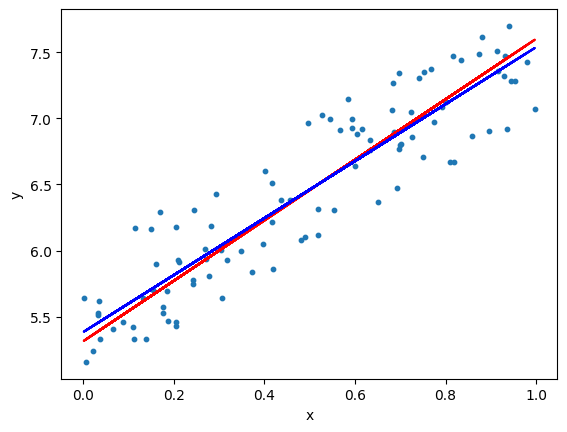

In [ ]:
import torch
import torch.nn.functional as F

torch.manual_seed(0)
x = torch.rand(100, 1)
y = 5 + 2 * x + torch.rand(100, 1)

W = torch.zeros((1, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def predict(x):
    y = x @ W + b
    return y

def mean_squared_error(x0, x1):
    diff = x0 - x1
    N = len(diff)
    return torch.sum(diff ** 2) / N

lr = 0.1
iters = 100

for i in range(iters):
    y_hat = predict(x)
    # loss = mean_squared_error(y, y_hat)
    loss = F.mse_loss(y, y_hat)

    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data

    W.grad.zero_()
    b.grad.zero_()

    if i % 10 == 0: # print every 10 iterations
        print(loss.item())

print(loss.item())
print('====')
print("\n추정된 회귀계수(beta) [수치적]:")
print('W =', W.item())
print('b =', b.item())

import numpy as np

# 행렬 연산을 활용한 해석적 해 구하기
x_ = x.detach().numpy()
y_ = y.detach().numpy()

# 절편을 위한 열 추가
x_matrix = np.hstack((np.ones((x_.shape[0], 1)), x_))

XtX_inv = np.linalg.inv(x_matrix.T @ x_matrix)
XtY = x_matrix.T @ y_
W_hat = XtX_inv @ XtY
W_hat = W_hat

print("\n추정된 회귀계수(beta) [해석적]:")
print('W =', W_hat[1])
print('b =', W_hat[0])

# plot
import matplotlib.pyplot as plt

plt.scatter(x_, y_, s=10)
x = torch.tensor([[0.0], [1.0]])

# 경사하강법을 이용한 선형회귀 직선
y_l = W.detach().numpy() * x_ + b.detach().numpy()
plt.plot(x_, y_l, color='red', label='Gradient Descent')

# 해석적 해를 이용한 선형회귀 직선
y_a = W_hat[1] * x_ + W_hat[0]
plt.plot(x_, y_a, color='blue', label='Analytic Solution')

plt.plot(x_, y_l, color='red')
plt.plot(x_, y_a, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### ℹ️ **참고**: 선형 회귀분석의 행렬 해석적 해법

선형 회귀분석(linear regression)은 입력 변수와 출력 변수 간의 선형적 관계를 찾는 통계적 방법입니다. 이 관계를 행렬을 활용해 나타내고, 이를 통해 해석적 해(solution)를 얻을 수 있습니다.

---

##### 선형 회귀의 행렬 표현

선형 회귀모델은 다음과 같이 표현할 수 있습니다.

$$
Y = X\beta + \epsilon
$$

여기서,

- $Y$: 관측된 종속변수 벡터 $(n \times 1)$
- $X$: 입력(설명)변수 행렬 $(n \times p)$, 여기서 $p$는 입력변수의 개수 (상수항 포함)
- $\beta$: 회귀계수 벡터 $(p \times 1)$
- $\epsilon$: 오차항 벡터 $(n \times 1)$, 평균은 0이고 분산은 일정하다고 가정

---

##### 최소제곱법(Least Squares Method)

회귀분석에서 계수 $\beta$를 찾는 방법 중 가장 널리 쓰이는 방법은 최소제곱법입니다. 최소제곱법의 목적은 실제값과 예측값의 오차 제곱합을 최소화하는 것입니다.

최소화할 식을 행렬 형태로 나타내면 다음과 같습니다.

$$
\min_{\beta} S(\beta) = (Y - X\beta)^T(Y - X\beta)
$$

---

##### 해석적 해(Analytic Solution)

위의 최소화 식을 풀어 계수 $\beta$를 찾으려면 미분을 통해 정규방정식(normal equation)을 얻습니다.

정규방정식의 유도 과정은 다음과 같습니다.

1. 목적 함수 $S(\beta)$를 $\beta$에 대해 미분

$$
\frac{\partial S(\beta)}{\partial \beta} = -2X^T(Y - X\beta)
$$

2. 미분한 결과를 0으로 두어 극소값 찾기

$$
X^T(Y - X\beta) = 0
$$

3. 정리하여 정규방정식을 얻음

$$
X^TX\beta = X^TY
$$

---

##### 최종 해석적 해

정규방정식에서 행렬 $X^TX$가 가역(invertible)일 때, 최종 해석적 해는 다음과 같습니다.

$$
\hat{\beta} = (X^TX)^{-1}X^TY
$$

여기서, $\hat{\beta}$는 최소제곱법으로 얻은 회귀계수의 추정치입니다.

---

##### 해석적 해의 의미

- 해석적 해는 빠르게 계산 가능하지만, 변수의 수가 많거나 다중공선성(multicollinearity)이 존재할 때는 수치적 문제가 생길 수 있습니다.
- 이러한 경우, 수치적 방법이나 규제된 방법(ridge, lasso 등)을 사용합니다.

---

이것이 선형 회귀분석의 행렬을 활용한 해석적 접근 방법입니다.




## 6.3 매개변수와 옵티마이저

신경망을 구현하다 보면 굉장히 많은 매개변수를 다루게 됩니다. 이 매개변수들을 일일이 관리하는 건 낭비죠. 그래서 파이토치는 매개변수들을 자동으로 관리해주는 메커니즘을 제공합니다. 예를 들어 다음 클래스들을 이용하면 매개변수들을 간편하게 관리할 수 있습니다.

- torch.mParameter
- torch.nn.Module
- torch.optim.SGD

이번에는 앞 절에서 푼 문제를 여기 세 클래스를 사용하여 다시 작성하겠습니다

### 6.3.1 Parameter 클래스와 Mockile 클래스

torch.nn.Parameter 클래스부터 설명하겠습니다. Parameter는 Tensor 클래스를 상속받은 클래스이며 인수로 tensor 인스턴스를 건네 생성합니다. 예를 들어 다음과 같이 사용합니다.

In [48]:
import torch 
import torch.nn as nn

W = nn.Parameter(torch.zeros(1, 1)) 
b = nn.Parameter(torch.zeros(1))

print(W) 
print(b)

Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


Parameter는 기본적으로 `requires_grad=True`로 설정되어 있습니다. 지금 코드에서 W와 b는 tensor와 동일하게 취급할 수 있습니다. 역전파하여 기울기를 구할 수도 있죠. 참고로 Parameter 인스턴스를 print()로 출력하면 ‘Parameter containing：’이라는 문구가 가장 먼 
저 출력됩니다.

Parameter 클래스는 Module 클래스와 함께 사용할 때 제대로 된 위력을 발휘힙니다. 사용 예를 먼저 보겠습니다.

In [ ]:
class Model(nn.Module): # 1. Module 클래스 상속
    def __init__(self):
        super().__init__() 
        self.W = nn.Parameter(torch.zeros(1, 1)) # 2.
        self.b = nn.Parameter(torch.zeros(1))

    def forward(self, x): # 3.
        y = x @ self.W + self.b 
        return y

model = Model()

# 4. 모델의 모든 매개변수에 접근할 수 있음 
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


1. `torch.nn.Module`을 상속하여 Model 클래스를 구현합니다.

2. Model의 속성으로 Parameter를 설정합니다.

3. 이 코드에서는 선형 회귀 계산을 `forward()` 메서드로 구현했습니다.  
   `forward()`는 순전파를 뜻합니다. 이 메서드를 이용하여 `y = model.forward(x)` 형태로 데이터를 순전파할 수 있으며,  
   `y = model(x)` 형태로도 같은 결과를 얻을 수 있습니다.

4. Model의 인스턴스(`model`)에서 `parameters()` 메서드를 호출하여 모델에 설정된 모든 매개변수를 가져올 수 있습니다.

참고로 파이토치에는 선형 변환을 수행하는 `torch.nn.Linear` 클래스가 준비되어 있습니다.    
선형 변환이란 \( y = Wx + b \) 형태의 계산입니다.   
Linear 클래스를 이용하면 방금 설명한 Model 클래스를 다음처럼 구현할 수 있습니다.  

In [51]:
class Model(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super().__init__()
        self .linear = nn. Linear(input_size, output_size) # Linear 클래스 시•용
    
    def forward(self, x):
        y = self.linear(x) # 앞에서는 y = x @ self.W + self.b
        return y 
    
model = Model()
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.0421]], requires_grad=True)
Parameter containing:
tensor([0.6446], requires_grad=True)


Linear 클래스의 인수에서 input size와 output_size는 입력할 벡터의 차원 수와 출력할 벡터의 차원 수입니다. 그리고 `self.linear(x)` 코드로 선형 변환 계산이 이루어집니다. Linear 인스턴스의 매개변수들은 `self.linear.W` 또는 `self.linear.b` 에서 확인할 수 있습니다. 또 
한 Linear 인스턴스의 매개변수는 Model 클래스의 매개변수로 자동 등록되므로 `model.parameters()`를 호출하면 Linear 인스턴스의 매개변수도 가져옵니다.

### 6.3.2 옵티마이저

최적화란 신경망의 매개변수를 갱신하는 알고리즘이고 옵티마이저 optimizer는 최적화 기법을 실제로 구현한 클래스입니다. 옵티마이저를 이용하면 앞 절과 똑같은 코드를 다음과 같이 구현할 수 있습니다.

0.09052946418523788
====

추정된 회귀계수(beta) [수치적]:
W = 2.2863590717315674
b = 5.3144850730896

추정된 회귀계수(beta) [해석적]:
W = [1.98100445]
b = [5.50123006]


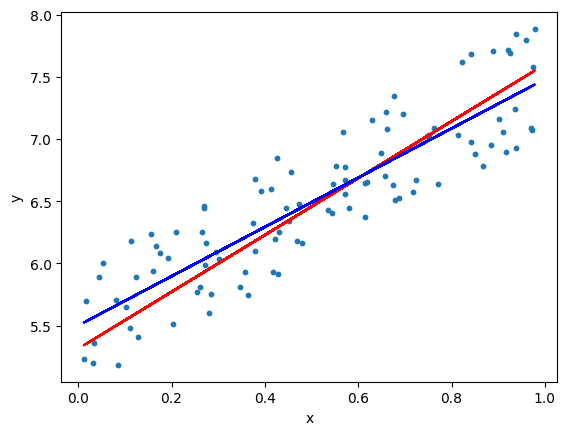

In [61]:
# 토이 데이터셋
x = torch.rand(100, 1) 
y = 5 + 2 * x + torch.rand(100, 1)

lr = 0.1 
iters = 100

model = Model()
optimizer = torch. optim. SGD(model. parameters(), lr=lr) # 1 옵티마이저 생성
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(iters):
    y_hat = model(x) 
    loss = nn.functional.mse_loss(y, y_hat)

    loss.backward()
    optimizer.step()        # 2 매개변수 갱신
    optimizer.zero_grad()   # 3 기울기 재설정s

print(loss.item())
print('====')
print("\n추정된 회귀계수(beta) [수치적]:")
print('W =', W.item())
print('b =', b.item())

import numpy as np

# 행렬 연산을 활용한 해석적 해 구하기
x_ = x.detach().numpy()
y_ = y.detach().numpy()

# 절편을 위한 열 추가
x_matrix = np.hstack((np.ones((x_.shape[0], 1)), x_))

XtX_inv = np.linalg.inv(x_matrix.T @ x_matrix)
XtY = x_matrix.T @ y_
W_hat = XtX_inv @ XtY
W_hat = W_hat

print("\n추정된 회귀계수(beta) [해석적]:")
print('W =', W_hat[1])
print('b =', W_hat[0])

# plot
import matplotlib.pyplot as plt

plt.scatter(x_, y_, s=10)
x = torch.tensor([[0.0], [1.0]])

# 경사하강법을 이용한 선형회귀 직선
y_l = W.detach().numpy() * x_ + b.detach().numpy()
plt.plot(x_, y_l, color='red', label='Gradient Descent')

# 해석적 해를 이용한 선형회귀 직선
y_a = W_hat[1] * x_ + W_hat[0]
plt.plot(x_, y_a, color='blue', label='Analytic Solution')

plt.plot(x_, y_l, color='red')
plt.plot(x_, y_a, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

파이토치의 `torch.optim` 패키지에는 다양한 최적화 기법이 담겨 있습니다. 여기서는 그중 `torch.optim.SGD` 클래스를 사용합니다.

1. SGD 클래스의 인스턴스를 생성했습니다. 최적화할 변수는 `model.parameters()`로 지정하고, 학습률은 `lr=0.1`로 지정했습니다.

> **NOTE**  
> **SGD**는 **stochastic gradient descent(확률적 경사 하강법)**의 약자입니다. 여기서 말하는 '확률적(stochastic)'이란 대상 데이터 중에서 무작위(확률적)로 샘플을 선별하고, 선별된 데이터에 대해 경사법을 수행한다는 뜻입니다. 딥러닝에서는 매개변수 최적화에 확률적 경사 하강법을 주로 사용합니다.

매개변수 갱신은  
2. 에서 `optimizer.step()`을 (매번) 호출하여 이루어집니다.  
3. 에서는 기울기를 재설정합니다. 이렇듯 옵티마이저를 이용하면 매개변수 갱신 코드가 숨겨집니다.

한편 기울기를 이용한 최적화 기법에는 매우 다양한데, 대표적으로 Momentum, AdaGrad, AdaDelta, Adam 등이 있습니다. 파이토치의 `torch.optim` 패키지에는 이러한 대표적인 최적화 기법들이 준비되어 있어서 다른 기법으로 손쉽게 바꿔가며 테스트할 수 있습니다. 예를 들어 앞의 코드에 Adam 기법을 적용하고 싶다면 다음 코드만 수정하면 됩니다.


## 6.4 신경망 구현

지금까지 파이토치를 이용해 선형 회귀를 구현하고 제대로 동작하는지 확인했습니다. 선형 회귀를 구현할 수 있다면 이를 신경망으로 확장하는 일은 간단합니다. 이번 절에서는 앞 절의 코드를 수정하여 신경망을 구현합니다.

### 6.4.1 비선형 데이터셋

6.2절에서는 선형 데이터에 노이즈를 더한 데이터셋을 사용했습니다. 이번 절에서는 복잡도를 높여서 관계가 다음 식과 같은 （財 이） 데이터셋을 다뤄보겠습니다.

$$ y = \sin(2 \pi x) + \epsilon$$

보다시피 sin 함수로 데이터를 생성하고 노이즈로 s을 추가합니다. s은 0에서 1 사이의 무작위 수입니다. 다음은 이 데이터셋을 생성하는 코드입니다.

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F


torch.manual_seed(0)
x = torch.rand(100, 1)
y = torch.sin(2 * torch.pi * x) + torch.rand(100, 1)

(x, y)의 점 100개를 생성했습니다. 만들어진 점들을 그래프로 나타내면 ［그림 6-8］과 같습니다.

<p align="center"><img src="./img/fig-06-08.png" width="50%"></p>

그림에서 보듯 x와y의 괸계는 선형이 아닙니다. 이와 같은 비선형 데이터셋은 당연히 선형 회귀로는 풀 수 없습니다. 신경망이 등장할 차례입니다.

### 6.4.2 선형 변환과 활성화 함수

6.2절에서는 간단한 데이터셋을 대상으로 선형 회귀를 구현했습니다. 선형 회귀에서 수행한 계산은 선형 변환입니다. 반면 신경망에서는 복잡하고 다양한 함수를 표현하기 위해 선형 변환의 출력에 비선형 변환을 수행합니다. 

이 비선형 변환을 수행하는 함수를 활성화 함수 activation function라고 합니다. 대표적으로 시그모이드 함수와 ReLU 함수 등이 있습니다.

<p align="center"><img src="./img/fig-06-09.png" width="50%"></p>

그림에서 보듯 시그모이드 함수와 ReLU 함수는 비선형입니다. 신경망에서는 이 그림과 같은 비선형 변환을 텐서 원소마다 적용합니다. 활성화 함수들은 다음과 같이 임포트하여 사용할 수 있습니다.

In [63]:
import torch.nn.functional as F

a = torch. rand(100, 5) # 무작위 텐서
b = F.sigmoid(a)
c = F.relu(a)

import torch.nn.functional as F로 가져오면 파이토치가 제공하는 시그모이드 함수와 ReLU 함수를 F.sigmoid()와 F.relu() 형태로 사용할 수 있습니다.

### 6.4.3 신경망 구현

일반적인 신경망은 선형 변환과 활성화 함수를 번갈아 사용합니다. 예를 들어 2층 신경망은 다음처럼 구현할 수 있습니다.

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# model
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size= 10, output_size=1):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        y = self.linear1(x)
        y = F.sigmoid(y)
        y = self.linear2(y)
        return y

nn.Modiile 클래스를 상속받았고 초기화 과정에서 선형 변환을 위한 nn.Linear 클래스를 2개 준비했습니다.  
그리고 forward() 메서드에서는 순전파를 [그림 6-1]과 같은 순서로 처리합니다.

<p align="center"><img src="./img/fig-06-10.png" width="50%"></p>

다음은 파이토치로 구현한 신경망 코드입니다

0.9632322788238525
0.23952198028564453
0.23782415688037872
0.2340301126241684
0.22124022245407104
0.18503552675247192
0.11827989667654037
0.08544427156448364
0.0822950005531311
0.08174033463001251
0.0814221203327179


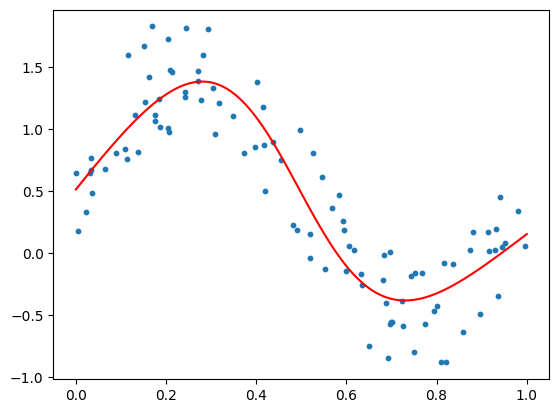

In [65]:
lr = 0.2
iters = 10000

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for i in range(iters):
    y_pred = model(x)
    loss = F.mse_loss(y, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(loss.item())

print(loss.item())

# plot
import matplotlib.pyplot as plt
plt.scatter(x.detach().numpy(), y.detach().numpy(), s=10)
x = torch.linspace(0, 1, 100).reshape(-1, 1)
y = model(x).detach().numpy()
plt.plot(x, y, color='red')
plt.show()

그림과 같이 sin 함수의 곡선을 잘 표현하고 있습니다. 이처럼 선형 회귀가 수행한 선형 변환에 활성화 함수를 덧씌우면 비선형 관계도 제대로 학습할 수 있습니다.

## 6.5 토치비전과 데이터셋

이번 절에서는 파이토치용 이미지 처리 라이브러리인 토치비전 torchvision에 대해 설명힙니다. 토치비전은 데이터셋 로딩과 이미지 전처리 등의 기능을 제공합니다. 또한 MNIST와 CIFAR-10 같은 유명한 데이터셋도 손쉽게 이용할 수 있게 해줍니다.

### 6.5.1 토치비전 설치

토치비전은 다음 명령어로 설치할 수 있습니다.

In [66]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [67]:
import torchvision

print(torchvision.__version__) # 0-15.0

0.19.1+cpu


### 6.5.2 MNIST 데이터셋

토치비전의 torchvision.datasets.MNIST 클래스를 이용하면 손글씨 숫자 이미지 데이터셋인 MNIST를 다운로드, 로드, 전처리할 수 있습니다.

size: 60000
type: <class 'PIL.Image.Image'>
label: 5


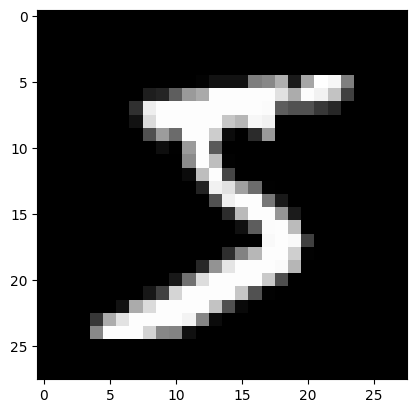

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1
## ==== MNIST ====
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=None,
    download=True
)

# 2
x, label = dataset[0]

print('size:', len(dataset))    # 3 size: 60000
print('type:', type(x))         # 4 type: <class 'PIL.Image.Image'>
print('label:', label)          # 5 label: 5

plt.imshow(x, cmap='gray')
plt.show()

torchvision.datasets.MNIST 클래스의 주요 인수들을 살펴봅시다.

- **root**: 데이터셋을 저장할 디렉터리를 지정한다. 로컬에 데이터셋이 아직 없다면 이 디렉터리에 다운로드한다.
- **train**: 값이 `True`면 학습용 데이터를 불러온다. `False`면 테스트용 데이터를 불러온다.
- **transform**: 이미지 데이터에 적용할 전처리를 지정한다.
- **download**: 값이 `True`면 `root` 인수로 지정한 디렉터리에 데이터셋이 존재하지 않을 시 자동으로 다운로드한다.

1. 앞의 코드에서 `dataset`에는 MNIST 데이터셋이 저장되어 있으며 인덱스를 지정하여 데이터를 가져올 수 있습니다.  
2. 예를 들어 `dataset[0]`은 첫 번째 데이터를 가져옵니다. 각 데이터에는 이미지와 레이블이 짝을 이루어 저장되어 있습니다.  
코드를 실행하면  
3. 총 6만 개의 데이터가 있고,  
4. 입력 이미지는 PIL.Image.Image이고,  
5. 첫 번째 데이터의 레이블은 ‘5’입니다. 마지막으로 [그림 6-12]를 출력합니다.


### 6.5.3 전처리

앞의 코드에서 사용한 MNIST 데이터셋은 입력 데이터가 PIL의 Image 클래스였습니다. 이 Image 클래스를 파이토치에서 사용하려면 Tensor 클래스로 변환해야 합니다. 일종의 전처리인 셈으로, 코드로는 다음처럼 작성할 수 있습니다.

In [73]:
# ==== preprocess ====
transform = transforms.ToTensor()

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

x, label = dataset[0]
print('type:', type(x))  # type: <class 'torch.Tensor'>
print('shape:', x.shape)  # shape: torch.Size([1, 28, 28])

type: <class 'torch.Tensor'>
shape: torch.Size([1, 28, 28])


파이토치에서 수행하는 전처리는 transforms 모듈에서 확인할 수 있습니다.  
지금 코드에서는 이미지를 파이토치의 텐서로 변환히는 transforms.ToTensor를 사용했습니 다.

### 6.5.4 데이터 로더

MNIST에는 총 6만 개의 데이터가 담겨 있습니다. 한꺼번에 학습하기에는 많은 양이라서 보통은 데이터셋을 분할하여 사용합니다.  
전체 데이터셋에서 일부만 추출하는 것을 미니배치 mini-batch 라고 합니다

미니배치로 학습할 때 데이터셋 전체를 1번 훑는 단위를 에포크 epoch라고 합니다.  
예를 들어 배치 크기가 100이라면 총 6만 개의 MNIST 데이터는 미니배치를 600번 처리해야 1에포크가 됩니다.

torch.utils.data.DataLoader를 사용하면 데이터셋에서 데이터를 미니배치 단위로 추출할 수 있습니다. 또한 에포크별로 데이터를 섞는 기능(셔플)도 있습니다. 어떻게 사용하는지 살펴보겠습니다.

In [ ]:
# ==== DataLoader ====
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,  # 1
    shuffle=True)

for x, label in dataloader: # 2
    print('x shape:', x.shape)  # shape: torch.Size([32, 1, 28, 28])
    print('label shape:', label.shape)  # shape: torch.Size([32])
    break

x shape: torch.Size([32, 1, 28, 28])
label shape: torch.Size([32])


torch.utils.data.DataLoader의 주요 인수는 다음과 같습니다.

- dataset : 불러올 데이터셋을 지정한다. 여기서는 앞서 불러온 MNIST 데이터셋을 지정했다.
- batch_size : 배치 크기를 지정한다.
- shuffle : 값이 True면 데이터를 에포크별로셔플한다.

지금 예에서는 1. 배치 크기를 32로 설정합니다. 데이터 로더를 사용하면 2. 와 같이 for 문을 사용하여 미니배치를 추출할 수 있습니다. 실행 결과를 보면 x의 형상은 ［32, 1, 28, 28］로, 미니배치 데이터가 텐서로 정리되어 있습니다. 

label의 형상은 [32]입니다. 마찬가지로 미니배치 단위로 정리되어 있음을 알 수 있습니다. 이상으로 토치비전을 살짝 훑어보았습니다. 이번 절에서 소개한 클래스들을 이용하면 데이터셋 로딩과 이미지 전처리를 손쉽게 구현할 수 있습니다.